# $pseudo$-VGPs

 APWP based on simulated VGPs (*pseudo*-VGPs) following the approach from Vaes et al. (2022)

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, PD)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import running_mean_APWP, RM_stats
from vgptools.utils_visualization import  RM_stats, plot_pseudoVGPs_and_APWP, plot_APWP_RM_ensemble, quantiles, plot_pole
np.random.seed(0)

Path to the VGP directory.

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

## Generate a DataFrame for both, the VGPs and the recomputed poles by study

In doing so, we calculate a pole for each study taking into account all the vgps within the same area/study

In [3]:
df_filtered_vgps, df_pole_compilation_by_study = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True)

In [4]:
df_pole_compilation_by_study.head()

,Study,pole,N,K,A95,slat,slon,Plat,Plon,min_age,max_age,mean_age
0,Absaroka_volcanics,NaN,44,11.076771,6.774448,44.613899,250.051065,-81.917678,328.575930,45.0000,54.0000,49.5000
1,Beaver_River_intrusions,NaN,21,44.972756,4.792312,60.238151,234.652209,-79.313242,327.669841,40.5000,43.5000,42.0000
2,Bighorn_Basin_sediments,NaN,59,10.640570,5.954672,44.459816,251.809627,-81.549042,2.761738,52.5400,59.2370,55.8885
3,Bishop_tuff,NaN,47,127.000000,1.900000,37.670000,241.250000,-80.164116,314.290252,0.7661,0.7679,0.7670
4,Bitterroot_Dome_intrusions,NaN,11,34.082686,7.933790,46.373039,245.107637,-72.178647,344.432968,46.4000,55.5000,50.9500


# Moving average on parametrically resampled vgps ('pseudo vgps')

First we need to generate a new dataset by drawing parametrically from the study-level poles.

In the present formulation the age of each *pseudo*-VGPs, it is taken at random between
the lower and upper bounds of the distribution of reported VGPs.

In [5]:
def get_pseudo_vgps(df):  
    '''
    takes a DF with paleomagnetic poles and respective statistics, it draws N randomly generated VGPs
    following the pole location and kappa concentration parameter. In the present formulation we follow
    a very conservative apporach for the assignaiton of ages to each VGP, it is taken at random between
    the lower and upper bounds of the distribution of reported VGPs.
    Note: column labels are presently hard-coded into this, if relevant.
    '''
    Study, age_bst, vgp_lat_bst, vgp_lon_bst = [], [], [], []

    for index, row in df.iterrows():
        
        # we first generate N VGPs following with N the number of VGPs from the original pole.
        directions_temp = ipmag.fishrot(k = row.K, n = row.N, dec = row.Plon, inc = row.Plat, di_block = False)
        
        vgp_lon_bst =  vgp_lon_bst + directions_temp[0]
        vgp_lat_bst = vgp_lat_bst + directions_temp[1]
    
        age_bst = age_bst + [np.random.randint(np.floor(row.min_age),np.ceil(row.max_age)) for _ in range(row.N)]
        Study = Study + [row.Study for _ in range(row.N)]
 
    dictionary = {
                  'Study': Study,
                  'Plat': vgp_lat_bst,    
                  'Plon': vgp_lon_bst,
                  'mean_age': age_bst
                  }    
    
    pseudo_vgps = pd.DataFrame(dictionary)

    return pseudo_vgps

In [6]:
%%time
df_pseudo_vgps = get_pseudo_vgps(df_pole_compilation_by_study)
df_pseudo_vgps.head(10)

Wall time: 196 ms


,Study,Plat,Plon,mean_age
0,Absaroka_volcanics,-71.145475,47.291735,46
1,Absaroka_volcanics,-80.122658,119.574524,49
2,Absaroka_volcanics,-71.143363,77.138110,51
3,Absaroka_volcanics,-61.016404,358.038331,53
4,Absaroka_volcanics,-84.441800,294.251956,47
5,Absaroka_volcanics,-85.898651,117.533946,48
6,Absaroka_volcanics,-64.148116,347.602872,45
7,Absaroka_volcanics,-42.519676,301.321079,45
8,Absaroka_volcanics,-36.031887,23.452990,51
9,Absaroka_volcanics,-71.312507,357.352364,45


# Applying the running mean on the *pseudo*-VGPs
We first apply the running mean method with the same parameter as in Torsvik et al. 2012 - a window lenght of 20 Ma and a time-step of 10 Ma.

In [8]:
min_age = 5
max_age = 65
window_length = 20
time_step = 10

RM_on_pseudoVGP = running_mean_APWP (df_pseudo_vgps, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_on_pseudoVGP.head(3)

,age,N,n_studies,k,A95,csd,plon,plat
0,5.0,352.0,15.0,23.913110,1.564911,16.564067,-20.697835,-86.956991
1,15.0,268.0,11.0,12.656341,2.516085,22.768317,-18.909190,-84.474739
2,25.0,298.0,10.0,10.553767,2.634825,24.933386,-21.005842,-81.377176


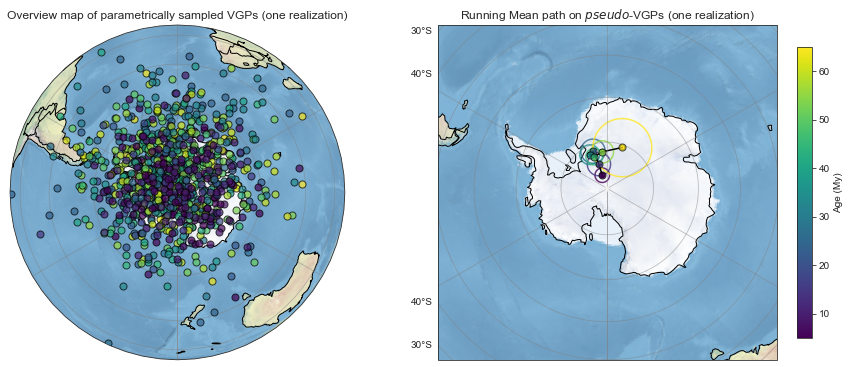

In [9]:
extent = [-180,180,-50,-50]
plot_pseudoVGPs_and_APWP(extent, df_pseudo_vgps, RM_on_pseudoVGP)
# plt.savefig(current_path + '/figures/3/3_AB_.svg', dpi =600, bbox_inches='tight')

### Bootstrapped age distribution

<AxesSubplot:title={'center':'Bootstrapped age distribution'}, xlabel='Mean Age (Ma)', ylabel='# of Paleomagentic Poles'>

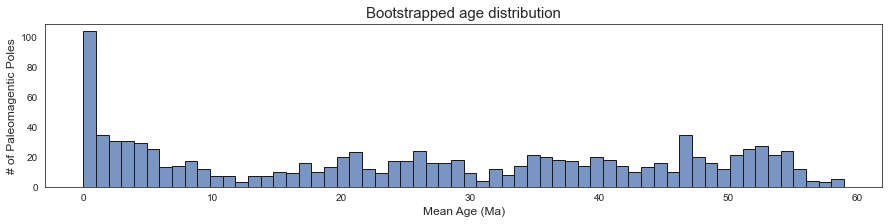

In [10]:
fig = plt.figure(figsize=(15,3))
sns.set_palette("deep")
plt.title('Bootstrapped age distribution', fontsize =15)
plt.ylabel('# of Paleomagentic Poles', fontsize = 12)
plt.xlabel('Mean Age (Ma)', fontsize = 12)
sns.histplot(data = df_pseudo_vgps, x = 'mean_age', bins = 60, legend = False, edgecolor=".1") 
# plt.savefig(current_path + '/figures/3/3_C.svg', dpi =600, bbox_inches='tight')

### Running Mean Statistics

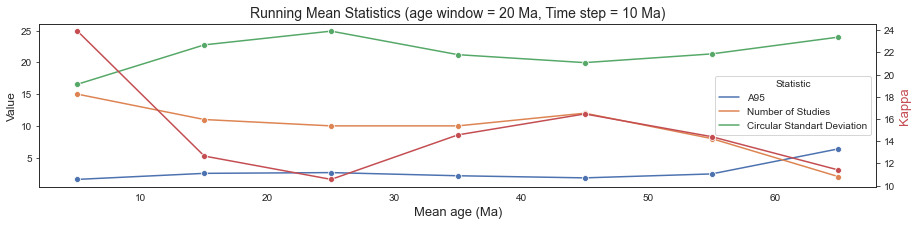

In [11]:
sns.set_palette("deep")
RM_stats(RM_on_pseudoVGP, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)","Age (Ma)","kappa")
# plt.savefig(current_path + '/figures/3/3_D.svg', dpi =600, bbox_inches='tight')

# APWP confidence bounds

Because we are taking a Monte Carlo approach, confidence on the mean cannot be assessed from one iteration. To generate confidence bounds on the APWP, we will apply the same approach a number of times in order to construct an ensemble of possible solutions that will allow us to construct empirical confidence bounds.

In [12]:
%%time
df_parametric_means_collection = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):
    
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation_by_study)
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i
    df_parametric_means_collection = df_parametric_means_collection.append(RM_APWP_parametric_temp, ignore_index=True)

df_parametric_means_collection['plon'] = df_parametric_means_collection.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)    

Wall time: 22.3 s


In [13]:
RM_ensemble_quant_plat = quantiles(df_parametric_means_collection,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_ensemble_quant_plon = quantiles(df_parametric_means_collection,"age","plon") # set quantiles of longitude groupedby age for visualization purposes

In [14]:
df_parametric_means_collection.head(5)

,run,n_studies,k,A95,csd,age,N,plon,plat
0,0,15.0,22.898153,1.605351,16.927187,5.0,350.0,-52.643160,-86.573226
1,0,11.0,12.705072,2.469496,22.724611,15.0,277.0,-30.653802,-83.806275
2,0,10.0,11.435511,2.578219,23.952852,25.0,285.0,-18.074360,-81.430294
3,0,10.0,14.133780,2.175112,21.545464,35.0,318.0,-16.854731,-83.478617
4,0,12.0,15.067741,1.889693,20.867045,45.0,393.0,-21.017382,-83.610352


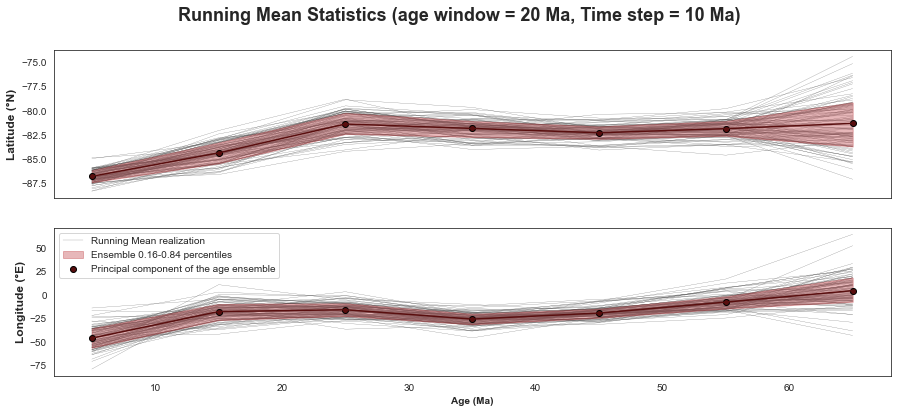

In [15]:
plot_APWP_RM_ensemble(df_parametric_means_collection, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)")
# plt.savefig(current_path + '/figures/3/3_E.svg', dpi =600, bbox_inches='tight')

## Example path

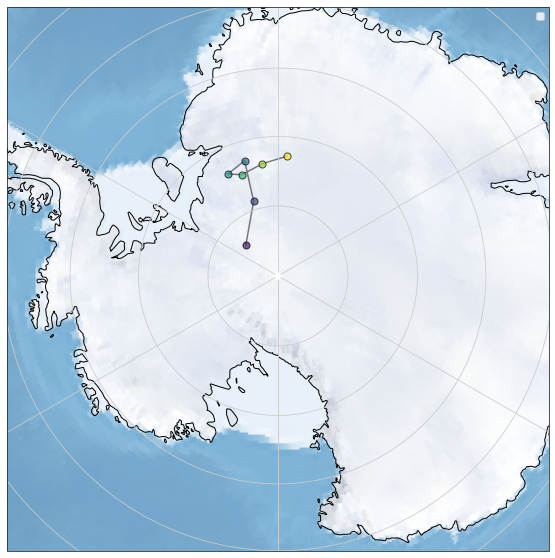

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon

extent = [-180,180,-70,-70]
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# sns.scatterplot(x = RM_ensembl_quant_plon.mean, y =RM_ensemble_quant_plat.mean,
                
#                 transform = ccrs.PlateCarree())
plt.plot(RM_ensemble_quant_plon.mean, RM_ensemble_quant_plat.mean,transform = ccrs.Geodetic(), color = "black", alpha = 0.5)

for i in zip(RM_ensemble_quant_plat.mean, RM_ensemble_quant_plon.mean, df_parametric_means_collection['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],0,65,ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()